$$
\newcommand{\argmax}{arg\,max}
\newcommand{\argmin}{arg\,min}
$$

# Optimal Savings II: Alternative Algorithms

# GPU

This lecture was built using a machine with access to a GPU.

[Google Colab](https://colab.research.google.com/) has a free tier with GPUs
that you can access as follows:

1. Click on the “play” icon top right  
1. Select Colab  
1. Set the runtime environment to include a GPU  


In [Optimal Savings I: Value Function Iteration](https://jax.quantecon.org/opt_savings_1.html) we solved a simple version of the household optimal
savings problem via value function iteration (VFI) using JAX.

In this lecture we tackle exactly the same problem while adding in two
alternative algorithms:

- optimistic policy iteration (OPI) and  
- Howard policy iteration (HPI).  


We will see that both of these algorithms outperform traditional VFI.

One reason for this is that the algorithms have good convergence properties.

Another is that one of them, HPI, is particularly well suited to pairing with
JAX.

The reason is that HPI uses a relatively small number of computationally expensive steps,
whereas VFI uses a longer sequence of small steps.

In other words, VFI is inherently more sequential than HPI, and sequential
routines are hard to parallelize.

By comparison, HPI is less sequential – the small number of computationally
intensive steps can be effectively parallelized by JAX.

This is particularly valuable when the underlying hardware includes a GPU.

Details on VFI, HPI and OPI can be found in [this book](https://dp.quantecon.org), for which a PDF is freely available.

Here we assume readers have some knowledge of the algorithms and focus on
computation.

For the details of the savings model, readers can refer to [Optimal Savings I: Value Function Iteration](https://jax.quantecon.org/opt_savings_1.html).

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

We will use the following imports:

In [2]:
import quantecon as qe
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Let’s check the GPU we are running.

In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


We’ll use 64 bit floats to gain extra precision.

In [4]:
jax.config.update("jax_enable_x64", True)

## Model primitives

First we define a model that stores parameters and grids.

The [following code](https://jax.quantecon.org/opt_savings_1.html#prgm-create-consumption-model) is repeated from [Optimal Savings I: Value Function Iteration](https://jax.quantecon.org/opt_savings_1.html).

In [5]:
def create_consumption_model(
    R=1.01,  # Gross interest rate
    β=0.98,  # Discount factor
    γ=2,  # CRRA parameter
    w_min=0.01,  # Min wealth
    w_max=5.0,  # Max wealth
    w_size=150,  # Grid side
    ρ=0.9,
    ν=0.1,
    y_size=100,
):  # Income parameters
    """
    A function that takes in parameters and returns parameters and grids
    for the optimal savings problem.
    """
    # Build grids and transition probabilities
    w_grid = jnp.linspace(w_min, w_max, w_size)
    mc = qe.tauchen(n=y_size, rho=ρ, sigma=ν)
    y_grid, Q = jnp.exp(mc.state_values), mc.P
    # Pack and return
    params = β, R, γ
    sizes = w_size, y_size
    arrays = w_grid, y_grid, jnp.array(Q)
    return params, sizes, arrays

Here’s the right hand side of the Bellman equation:

In [6]:
def _B(v, params, arrays, i, j, ip):
    """
    The right-hand side of the Bellman equation before maximization, which takes
    the form

        B(w, y, w′) = u(Rw + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)

    The indices are (i, j, ip) -> (w, y, w′).
    """
    β, R, γ = params
    w_grid, y_grid, Q = arrays
    w, y, wp = w_grid[i], y_grid[j], w_grid[ip]
    c = R * w + y - wp
    EV = jnp.sum(v[ip, :] * Q[j, :])
    return jnp.where(c > 0, c ** (1 - γ) / (1 - γ) + β * EV, -jnp.inf)

Now we successively apply `vmap` to vectorize $ B $ by simulating nested loops.

In [7]:
B_1 = jax.vmap(_B, in_axes=(None, None, None, None, None, 0))
B_2 = jax.vmap(B_1, in_axes=(None, None, None, None, 0, None))
B_vmap = jax.vmap(B_2, in_axes=(None, None, None, 0, None, None))

Here’s a fully vectorized version of $ B $.

In [8]:
def B(v, params, sizes, arrays):
    w_size, y_size = sizes
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return B_vmap(v, params, arrays, w_indices, y_indices, w_indices)


B = jax.jit(B, static_argnums=(2,))

## Operators

Here’s the Bellman operator $ T $

In [9]:
def T(v, params, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B(v, params, sizes, arrays), axis=-1)


T = jax.jit(T, static_argnums=(2,))

The next function computes a $ v $-greedy policy given $ v $

In [10]:
def get_greedy(v, params, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, params, sizes, arrays), axis=-1)


get_greedy = jax.jit(get_greedy, static_argnums=(2,))

We define a function to compute the current rewards $ r_\sigma $ given policy $ \sigma $,
which is defined as the vector

$$
r_\sigma(w, y) := r(w, y, \sigma(w, y))
$$

In [11]:
def _compute_r_σ(σ, params, arrays, i, j):
    """
    With indices (i, j) -> (w, y) and wp = σ[i, j], compute

        r_σ[i, j] = u(Rw + y - wp)

    which gives current rewards under policy σ.
    """

    # Unpack model
    β, R, γ = params
    w_grid, y_grid, Q = arrays
    # Compute r_σ[i, j]
    w, y, wp = w_grid[i], y_grid[j], w_grid[σ[i, j]]
    c = R * w + y - wp
    r_σ = c ** (1 - γ) / (1 - γ)

    return r_σ

Now we successively apply `vmap` to simulate nested loops.

In [12]:
r_1 = jax.vmap(_compute_r_σ, in_axes=(None, None, None, None, 0))
r_σ_vmap = jax.vmap(r_1, in_axes=(None, None, None, 0, None))

Here’s a fully vectorized version of $ r_\sigma $.

In [13]:
def compute_r_σ(σ, params, sizes, arrays):
    w_size, y_size = sizes
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return r_σ_vmap(σ, params, arrays, w_indices, y_indices)


compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))

Now we define the policy operator $ T_\sigma $ going through similar steps

In [14]:
def _T_σ(v, σ, params, arrays, i, j):
    "The σ-policy operator."

    # Unpack model
    β, R, γ = params
    w_grid, y_grid, Q = arrays

    r_σ = _compute_r_σ(σ, params, arrays, i, j)
    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    EV = jnp.sum(v[σ[i, j], :] * Q[j, :])

    return r_σ + β * EV


T_1 = jax.vmap(_T_σ, in_axes=(None, None, None, None, None, 0))
T_σ_vmap = jax.vmap(T_1, in_axes=(None, None, None, None, 0, None))


def T_σ(v, σ, params, sizes, arrays):
    w_size, y_size = sizes
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return T_σ_vmap(v, σ, params, arrays, w_indices, y_indices)


T_σ = jax.jit(T_σ, static_argnums=(3,))

The function below computes the value $ v_\sigma $ of following policy $ \sigma $.

This lifetime value is a function $ v_\sigma $ that satisfies

$$
v_\sigma(w, y) = r_\sigma(w, y) + \beta \sum_{y'} v_\sigma(\sigma(w, y), y') Q(y, y')
$$

We wish to solve this equation for $ v_\sigma $.

Suppose we define the linear operator $ L_\sigma $ by

$$
(L_\sigma v)(w, y) = v(w, y) - \beta \sum_{y'} v(\sigma(w, y), y') Q(y, y')
$$

With this notation, the problem is to solve for $ v $ via

$$
(L_{\sigma} v)(w, y) = r_\sigma(w, y)
$$

In vector for this is $ L_\sigma v = r_\sigma $, which tells us that the function
we seek is

$$
v_\sigma = L_\sigma^{-1} r_\sigma
$$

JAX allows us to solve linear systems defined in terms of operators; the first
step is to define the function $ L_{\sigma} $.

In [15]:
def _L_σ(v, σ, params, arrays, i, j):
    """
    Here we set up the linear map v -> L_σ v, where

        (L_σ v)(w, y) = v(w, y) - β Σ_y′ v(σ(w, y), y′) Q(y, y′)

    """
    # Unpack
    β, R, γ = params
    w_grid, y_grid, Q = arrays
    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v[i, j] - β * jnp.sum(v[σ[i, j], :] * Q[j, :])


L_1 = jax.vmap(_L_σ, in_axes=(None, None, None, None, None, 0))
L_σ_vmap = jax.vmap(L_1, in_axes=(None, None, None, None, 0, None))


def L_σ(v, σ, params, sizes, arrays):
    w_size, y_size = sizes
    w_indices, y_indices = jnp.arange(w_size), jnp.arange(y_size)
    return L_σ_vmap(v, σ, params, arrays, w_indices, y_indices)


L_σ = jax.jit(L_σ, static_argnums=(3,))

Now we can define a function to compute $ v_{\sigma} $

In [16]:
def get_value(σ, params, sizes, arrays):
    "Get the value v_σ of policy σ by inverting the linear map L_σ."

    # Unpack
    β, R, γ = params
    w_size, y_size = sizes
    w_grid, y_grid, Q = arrays

    r_σ = compute_r_σ(σ, params, sizes, arrays)

    # Reduce L_σ to a function in v
    partial_L_σ = lambda v: L_σ(v, σ, params, sizes, arrays)

    return jax.scipy.sparse.linalg.bicgstab(partial_L_σ, r_σ)[0]


get_value = jax.jit(get_value, static_argnums=(2,))

## Iteration

We use successive approximation for VFI.

In [17]:
def successive_approx_jax(
    T,  # Operator (callable)
    x_0,  # Initial condition
    tol=1e-6,  # Error tolerance
    max_iter=10_000,
):  # Max iteration bound
    def update(inputs):
        k, x, error = inputs
        x_new = T(x)
        error = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, error

    def condition_function(inputs):
        k, x, error = inputs
        return jnp.logical_and(error > tol, k < max_iter)

    k, x, error = jax.lax.while_loop(condition_function, update, (1, x_0, tol + 1))
    return x


successive_approx_jax = jax.jit(successive_approx_jax, static_argnums=(0,))

For OPI we’ll add a compiled routine that computes $ T_σ^m v $.

In [18]:
def iterate_policy_operator(σ, v, m, params, sizes, arrays):
    def update(i, v):
        v = T_σ(v, σ, params, sizes, arrays)
        return v

    v = jax.lax.fori_loop(0, m, update, v)
    return v


iterate_policy_operator = jax.jit(iterate_policy_operator, static_argnums=(4,))

## Solvers

Now we define the solvers, which implement VFI, HPI and OPI.

Here’s VFI.

In [19]:
def value_function_iteration(model, tol=1e-5):
    """
    Implements value function iteration.
    """
    params, sizes, arrays = model
    vz = jnp.zeros(sizes)
    _T = lambda v: T(v, params, sizes, arrays)
    v_star = successive_approx_jax(_T, vz, tol=tol)
    return get_greedy(v_star, params, sizes, arrays)

For OPI we will use a compiled JAX `lax.while_loop` operation to speed execution.

In [20]:
def opi_loop(params, sizes, arrays, m, tol, max_iter):
    """
    Implements optimistic policy iteration (see dp.quantecon.org) with
    step size m.

    """
    v_init = jnp.zeros(sizes)

    def condition_function(inputs):
        i, v, error = inputs
        return jnp.logical_and(error > tol, i < max_iter)

    def update(inputs):
        i, v, error = inputs
        last_v = v
        σ = get_greedy(v, params, sizes, arrays)
        v = iterate_policy_operator(σ, v, m, params, sizes, arrays)
        error = jnp.max(jnp.abs(v - last_v))
        i += 1
        return i, v, error

    num_iter, v, error = jax.lax.while_loop(
        condition_function, update, (0, v_init, tol + 1)
    )

    return get_greedy(v, params, sizes, arrays)


opi_loop = jax.jit(opi_loop, static_argnums=(1,))

Here’s a friendly interface to OPI

In [21]:
def optimistic_policy_iteration(model, m=10, tol=1e-5, max_iter=10_000):
    params, sizes, arrays = model
    σ_star = opi_loop(params, sizes, arrays, m, tol, max_iter)
    return σ_star

Here’s HPI.

In [22]:
def howard_policy_iteration(model, maxiter=250):
    """
    Implements Howard policy iteration (see dp.quantecon.org)
    """
    params, sizes, arrays = model
    σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0 and i < maxiter:
        v_σ = get_value(σ, params, sizes, arrays)
        σ_new = get_greedy(v_σ, params, sizes, arrays)
        error = jnp.max(jnp.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ

## Tests

Let’s create a model for consumption, and plot the resulting optimal policy function using all the three algorithms and also check the time taken by each solver.

In [23]:
model = create_consumption_model()
# Unpack
params, sizes, arrays = model
β, R, γ = params
w_size, y_size = sizes
w_grid, y_grid, Q = arrays

In [24]:
print("Starting HPI.")
start = time()
σ_star_hpi = howard_policy_iteration(model).block_until_ready()
hpi_with_compile = time() - start
print(f"HPI completed in {hpi_with_compile} seconds.")

Starting HPI.
Concluded loop 1 with error 77.
Concluded loop 2 with error 53.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 8.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 1.
Concluded loop 13 with error 1.
Concluded loop 14 with error 1.
Concluded loop 15 with error 1.
Concluded loop 16 with error 1.
Concluded loop 17 with error 1.
Concluded loop 18 with error 1.
Concluded loop 19 with error 1.
Concluded loop 20 with error 1.
Concluded loop 21 with error 1.
Concluded loop 22 with error 1.
Concluded loop 23 with error 1.
Concluded loop 24 with error 1.
Concluded loop 25 with error 1.
Concluded loop 26 with error 1.
Concluded loop 27 with error 1.
Concluded loop 28 with error 1.
Concluded loop 29 with error 1.
Concluded loop 30 with error 1.
Concluded loop 31 with error 1.

We run it again to get rid of compile time.

In [25]:
start = time()
σ_star_hpi = howard_policy_iteration(model).block_until_ready()
hpi_without_compile = time() - start
print(f"HPI completed in {hpi_without_compile} seconds.")

Concluded loop 1 with error 77.
Concluded loop 2 with error 53.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 8.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 1.
Concluded loop 13 with error 1.
Concluded loop 14 with error 1.
Concluded loop 15 with error 1.
Concluded loop 16 with error 1.
Concluded loop 17 with error 1.
Concluded loop 18 with error 1.
Concluded loop 19 with error 1.
Concluded loop 20 with error 1.
Concluded loop 21 with error 1.
Concluded loop 22 with error 1.
Concluded loop 23 with error 1.
Concluded loop 24 with error 1.
Concluded loop 25 with error 1.
Concluded loop 26 with error 1.
Concluded loop 27 with error 1.
Concluded loop 28 with error 1.
Concluded loop 29 with error 1.
Concluded loop 30 with error 1.
Concluded loop 31 with error 1.
Concluded loo

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/var/folders/s9/94vsjp21473gbgm66xdz80k00000gn/T/ipykernel_18651/1399712274.py:3: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(w_grid, w_grid[σ_star_hpi[:, 1]], label="$\\sigma^{*}_{HPI}(\cdot, y_1)$")
/var/folders/s9/94vsjp21473gbgm66xdz80k00000gn/T/ipykernel_18651/1399712274.py:4: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(w_grid, w_grid[σ_star_hpi[:, -1]], label="$\\sigma^{*}_{HPI}(\cdot, y_N)$")


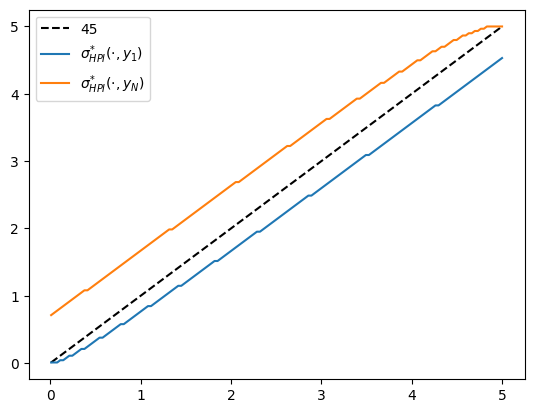

In [26]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star_hpi[:, 1]], label="$\\sigma^{*}_{HPI}(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star_hpi[:, -1]], label="$\\sigma^{*}_{HPI}(\cdot, y_N)$")
ax.legend()
plt.show()

In [27]:
print("Starting VFI.")
start = time()
σ_star_vfi = value_function_iteration(model).block_until_ready()
vfi_with_compile = time() - start
print(f"VFI completed in {vfi_with_compile} seconds.")

Starting VFI.
VFI completed in 0.36354827880859375 seconds.


We run it again to eliminate compile time.

In [28]:
start = time()
σ_star_vfi = value_function_iteration(model).block_until_ready()
vfi_without_compile = time() - start
print(f"VFI completed in {vfi_without_compile} seconds.")

VFI completed in 0.32384610176086426 seconds.


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/var/folders/s9/94vsjp21473gbgm66xdz80k00000gn/T/ipykernel_18651/2375303016.py:3: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(w_grid, w_grid[σ_star_vfi[:, 1]], label="$\\sigma^{*}_{VFI}(\cdot, y_1)$")
/var/folders/s9/94vsjp21473gbgm66xdz80k00000gn/T/ipykernel_18651/2375303016.py:4: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(w_grid, w_grid[σ_star_vfi[:, -1]], label="$\\sigma^{*}_{VFI}(\cdot, y_N)$")


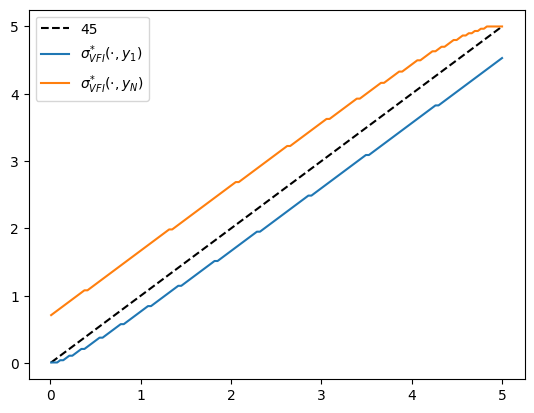

In [29]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star_vfi[:, 1]], label="$\\sigma^{*}_{VFI}(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star_vfi[:, -1]], label="$\\sigma^{*}_{VFI}(\cdot, y_N)$")
ax.legend()
plt.show()

In [30]:
print("Starting OPI.")
start = time()
σ_star_opi = optimistic_policy_iteration(model, m=100).block_until_ready()
opi_with_compile = time() - start
print(f"OPI completed in {opi_with_compile} seconds.")

Starting OPI.
OPI completed in 0.28436923027038574 seconds.


Let’s run it again to get rid of compile time.

In [31]:
start = time()
σ_star_opi = optimistic_policy_iteration(model, m=100).block_until_ready()
opi_without_compile = time() - start
print(f"OPI completed in {opi_without_compile} seconds.")

OPI completed in 0.2001338005065918 seconds.


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/var/folders/s9/94vsjp21473gbgm66xdz80k00000gn/T/ipykernel_18651/3919766253.py:3: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(w_grid, w_grid[σ_star_opi[:, 1]], label="$\\sigma^{*}_{OPI}(\cdot, y_1)$")
/var/folders/s9/94vsjp21473gbgm66xdz80k00000gn/T/ipykernel_18651/3919766253.py:4: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(w_grid, w_grid[σ_star_opi[:, -1]], label="$\\sigma^{*}_{OPI}(\cdot, y_N)$")


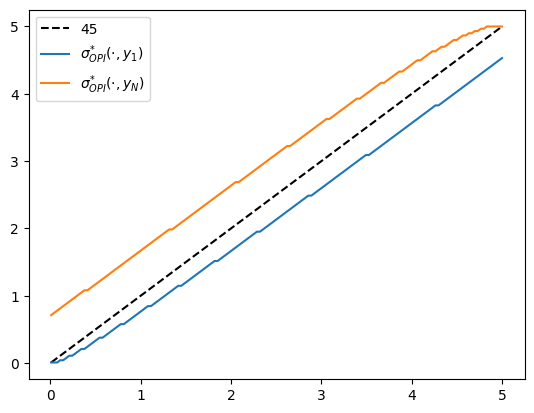

In [32]:
fig, ax = plt.subplots()
ax.plot(w_grid, w_grid, "k--", label="45")
ax.plot(w_grid, w_grid[σ_star_opi[:, 1]], label="$\\sigma^{*}_{OPI}(\cdot, y_1)$")
ax.plot(w_grid, w_grid[σ_star_opi[:, -1]], label="$\\sigma^{*}_{OPI}(\cdot, y_N)$")
ax.legend()
plt.show()

We observe that all the solvers produce the same output from the above three plots.

Now, let’s create a plot to visualize the time differences among these algorithms.

In [33]:
def run_algorithm(algorithm, model, **kwargs):
    result = algorithm(model, **kwargs)

    # Now time it without compile time
    start = time()
    result = algorithm(model, **kwargs).block_until_ready()
    algorithm_without_compile = time() - start
    print(f"{algorithm.__name__} completed in {algorithm_without_compile:.2f} seconds.")
    return result, algorithm_without_compile

In [34]:
σ_pi, pi_time = run_algorithm(howard_policy_iteration, model)
σ_vfi, vfi_time = run_algorithm(value_function_iteration, model, tol=1e-5)

Concluded loop 1 with error 77.
Concluded loop 2 with error 53.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 8.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 1.
Concluded loop 13 with error 1.
Concluded loop 14 with error 1.
Concluded loop 15 with error 1.
Concluded loop 16 with error 1.
Concluded loop 17 with error 1.
Concluded loop 18 with error 1.
Concluded loop 19 with error 1.
Concluded loop 20 with error 1.
Concluded loop 21 with error 1.
Concluded loop 22 with error 1.
Concluded loop 23 with error 1.
Concluded loop 24 with error 1.
Concluded loop 25 with error 1.
Concluded loop 26 with error 1.
Concluded loop 27 with error 1.
Concluded loop 28 with error 1.
Concluded loop 29 with error 1.
Concluded loop 30 with error 1.
Concluded loop 31 with error 1.
Concluded loo

In [35]:
m_vals = range(5, 600, 40)
opi_times = []
for m in m_vals:
    σ_opi, opi_time = run_algorithm(optimistic_policy_iteration, model, m=m, tol=1e-5)
    opi_times.append(opi_time)

optimistic_policy_iteration completed in 0.50 seconds.
optimistic_policy_iteration completed in 0.30 seconds.
optimistic_policy_iteration completed in 0.33 seconds.
optimistic_policy_iteration completed in 0.40 seconds.
optimistic_policy_iteration completed in 0.51 seconds.
optimistic_policy_iteration completed in 0.60 seconds.
optimistic_policy_iteration completed in 0.73 seconds.
optimistic_policy_iteration completed in 0.85 seconds.
optimistic_policy_iteration completed in 0.95 seconds.
optimistic_policy_iteration completed in 1.07 seconds.
optimistic_policy_iteration completed in 1.21 seconds.
optimistic_policy_iteration completed in 1.32 seconds.
optimistic_policy_iteration completed in 1.41 seconds.
optimistic_policy_iteration completed in 1.58 seconds.
optimistic_policy_iteration completed in 1.65 seconds.


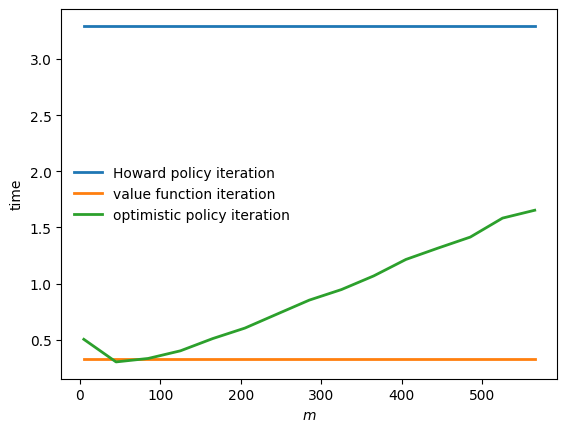

In [36]:
fig, ax = plt.subplots()
ax.plot(
    m_vals,
    jnp.full(len(m_vals), hpi_without_compile),
    lw=2,
    label="Howard policy iteration",
)
ax.plot(
    m_vals,
    jnp.full(len(m_vals), vfi_without_compile),
    lw=2,
    label="value function iteration",
)
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(frameon=False)
ax.set_xlabel("$m$")
ax.set_ylabel("time")
plt.show()